In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

## Fonctions utiles

In [2]:
def display(states,li_titles):
    fig = plt.figure(figsize=(11, 11))
    
    # setting values to rows and column variables
    n = len(states)
    rows = int(np.sqrt(n))+1
    columns = n // (rows-1)
    
    for i in range(n):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(states[i])
        plt.axis('off')
        plt.title(li_titles[i])

In [2]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [3]:
dict_labels = {"awake" : 0, "light-propofol" : 1, "deep-propofol" : 2}
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
fc_train = torch.squeeze(fc_train,dim=2)
fc_train_vector = package.preprocessing.flatten_higher_triangular(fc_train)
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["awake","light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

dfc_test = dfc[meta["monkey"] == "jade"].reshape((-1, n_wins, 82, 82))
fc_test = torch.from_numpy(dfc_test.reshape((dfc_test.shape[0],464,1,82,82)))
fc_test = torch.squeeze(fc_test,dim=2)
fc_test_vector = package.preprocessing.flatten_higher_triangular(fc_test)
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["awake","light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

dfc_all = dfc.reshape((-1, n_wins, 82, 82))

In [4]:
dfc_train_awake = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake']))].reshape((-1, n_wins, 82, 82))
fc_train_awake = torch.from_numpy(dfc_train_awake.reshape((dfc_train_awake.shape[0],464,1,82,82)))
fc_train_awake = torch.squeeze(fc_train_awake,dim=2)
fc_train_awake_vector = package.preprocessing.flatten_higher_triangular(fc_train_awake)

dfc_train_anaesthesized = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train_anaesthesized = torch.from_numpy(dfc_train_anaesthesized.reshape((dfc_train_anaesthesized.shape[0],464,1,82,82)))
fc_train_anaesthesized = torch.squeeze(fc_train_anaesthesized,dim=2)
fc_train_anaesthesized_vector = package.preprocessing.flatten_higher_triangular(fc_train_anaesthesized)

dfc_train_light_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train_light_propofol = torch.from_numpy(dfc_train_light_propofol.reshape((dfc_train_light_propofol.shape[0],464,1,82,82)))
fc_train_light_propofol = torch.squeeze(fc_train_light_propofol,dim=2)
fc_train_light_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_train_light_propofol)

dfc_train_deep_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train_deep_propofol = torch.from_numpy(dfc_train_deep_propofol.reshape((dfc_train_deep_propofol.shape[0],464,1,82,82)))
fc_train_deep_propofol = torch.squeeze(fc_train_deep_propofol,dim=2)
fc_train_deep_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_train_deep_propofol)

dfc_test_awake = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['awake']))].reshape((-1, n_wins, 82, 82))
fc_test_awake = torch.from_numpy(dfc_test_awake.reshape((dfc_test_awake.shape[0],464,1,82,82)))
fc_test_awake = torch.squeeze(fc_test_awake,dim=2)
fc_test_awake_vector = package.preprocessing.flatten_higher_triangular(fc_test_awake)

dfc_test_anaesthesized = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_test_anaesthesized = torch.from_numpy(dfc_test_anaesthesized.reshape((dfc_test_anaesthesized.shape[0],464,1,82,82)))
fc_test_anaesthesized = torch.squeeze(fc_test_anaesthesized,dim=2)
fc_test_anaesthesized_vector = package.preprocessing.flatten_higher_triangular(fc_test_anaesthesized)

dfc_test_light_propofol = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol']))].reshape((-1, n_wins, 82, 82))
fc_test_light_propofol = torch.from_numpy(dfc_test_light_propofol.reshape((dfc_test_light_propofol.shape[0],464,1,82,82)))
fc_test_light_propofol = torch.squeeze(fc_test_light_propofol,dim=2)
fc_test_light_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_test_light_propofol)

dfc_test_deep_propofol = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_test_deep_propofol = torch.from_numpy(dfc_test_deep_propofol.reshape((dfc_test_deep_propofol.shape[0],464,1,82,82)))
fc_test_deep_propofol = torch.squeeze(fc_test_deep_propofol,dim=2)
fc_test_deep_propofol_vector = package.preprocessing.flatten_higher_triangular(fc_test_deep_propofol)

## Contrastive PCA (ma méthode)

In [171]:
a,b = labels_train.shape
Y = labels_train.reshape((a*b,1))
enc = OneHotEncoder()
Y = sc.sparse.csr_matrix.toarray(enc.fit_transform(Y))
Y = StandardScaler().fit_transform(Y)

In [172]:
alpha = 100
a,b,c = fc_train_vector.shape
X = fc_train_vector.reshape((a*b,c))
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X = np.concatenate((X,alpha*Y),axis = 1)
C_train = (X.T @ X) / X.shape[0]

In [154]:
eigenvalues,eigenvectors = sc.linalg.eig(C_train)

In [157]:
X_transformed = X @ eigenvectors

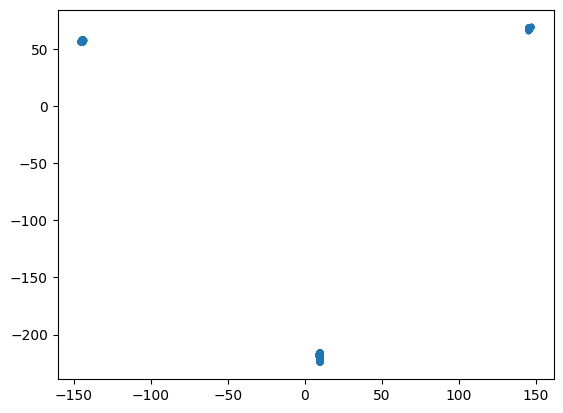

In [168]:
plt.scatter(X_transformed[:,0].flatten(),X_transformed[:,1].flatten(),marker = '.')

In [176]:
a,b,c = fc_train_anaesthesized_vector.shape
X_train_anaesthesized = fc_train_anaesthesized_vector.reshape((a*b,c))
X_train_anaesthesized = scalerX.transform(X_train_anaesthesized)
X_train_anaesthesized_transformed = X_train_anaesthesized @ eigenvectors

d,e,f = fc_train_awake_vector.shape
X_train_awake = fc_train_awake_vector.reshape((d*e,f))
X_train_awake = scalerY.transform(X_train_awake)
X_train_awake_transformed = X_train_awake @ eigenvectors

a,b,c = fc_train_light_propofol_vector.shape
X_train_light_propofol = fc_train_light_propofol_vector.reshape((a*b,c))
X_train_light_propofol = scalerX.transform(X_train_light_propofol)
X_train_light_propofol_transformed = X_train_light_propofol @ eigenvectors

d,e,f = fc_train_deep_propofol_vector.shape
X_train_deep_propofol = fc_train_deep_propofol_vector.reshape((d*e,f))
X_train_deep_propofol = scalerX.transform(X_train_deep_propofol)
X_train_deep_propofol_transformed = X_train_deep_propofol @ eigenvectors

a,b,c = fc_test_anaesthesized_vector.shape
X_test_anaesthesized = fc_test_anaesthesized_vector.reshape((a*b,c))
X_test_anaesthesized = scalerX.transform(X_test_anaesthesized)
X_test_anaesthesized_transformed = X_test_anaesthesized @ eigenvectors

d,e,f = fc_test_awake_vector.shape
X_test_awake = fc_test_awake_vector.reshape((d*e,f))
X_test_awake = scalerY.transform(X_test_awake)
X_test_awake_transformed = X_test_awake @ eigenvectors

a,b,c = fc_test_light_propofol_vector.shape
X_test_light_propofol = fc_test_light_propofol_vector.reshape((a*b,c))
X_test_light_propofol = scalerX.transform(X_test_light_propofol)
X_test_light_propofol_transformed = X_test_light_propofol @ eigenvectors

d,e,f = fc_test_deep_propofol_vector.shape
X_test_deep_propofol = fc_test_deep_propofol_vector.reshape((d*e,f))
X_test_deep_propofol = scalerX.transform(X_test_deep_propofol)
X_test_deep_propofol_transformed = X_test_deep_propofol @ eigenvectors

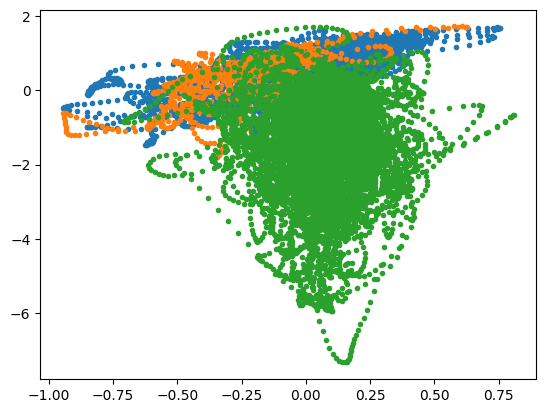

In [182]:
plt.scatter(X_test_deep_propofol_transformed[:,0].flatten(),X_test_deep_propofol_transformed[:,1].flatten(),marker='.')
plt.scatter(X_test_light_propofol_transformed[:,0].flatten(),X_test_light_propofol_transformed[:,1].flatten(),marker='.')
plt.scatter(X_test_awake_transformed[:,0].flatten(),X_test_awake_transformed[:,1].flatten(),marker='.')

## Méthode du papier

### Awake vs Anaesthesized

In [29]:
alpha = 10

a,b,c = fc_train_awake_vector.shape
X = fc_train_awake_vector.reshape((a*b,c))

d,e,f = fc_train_anaesthesized_vector.shape
Y = fc_train_anaesthesized_vector.reshape((d*e,f))

scalerX = StandardScaler().fit(X)
X = scalerX.transform(X)
C_X = (X.T @ X) / X.shape[0]

scalerY = StandardScaler().fit(Y)
Y = scalerX.transform(Y)
C_Y = (Y.T @ Y) / Y.shape[0]

C = C_X - alpha * C_Y

In [30]:
eig = sc.linalg.eig(C)
eigenvectors = eig[1]
eigenvalues = eig[0]

In [31]:
X_transformed = X @ eigenvectors

In [32]:
a,b,c = fc_train_anaesthesized_vector.shape
X_train_anaesthesized = fc_train_anaesthesized_vector.reshape((a*b,c))
X_train_anaesthesized = scalerX.transform(X_train_anaesthesized)
X_train_anaesthesized_transformed = X_train_anaesthesized @ eigenvectors

d,e,f = fc_train_awake_vector.shape
X_train_awake = fc_train_awake_vector.reshape((d*e,f))
X_train_awake = scalerY.transform(X_train_awake)
X_train_awake_transformed = X_train_awake @ eigenvectors

a,b,c = fc_train_light_propofol_vector.shape
X_train_light_propofol = fc_train_light_propofol_vector.reshape((a*b,c))
X_train_light_propofol = scalerX.transform(X_train_light_propofol)
X_train_light_propofol_transformed = X_train_light_propofol @ eigenvectors

d,e,f = fc_train_deep_propofol_vector.shape
X_train_deep_propofol = fc_train_deep_propofol_vector.reshape((d*e,f))
X_train_deep_propofol = scalerX.transform(X_train_deep_propofol)
X_train_deep_propofol_transformed = X_train_deep_propofol @ eigenvectors

a,b,c = fc_test_anaesthesized_vector.shape
X_test_anaesthesized = fc_test_anaesthesized_vector.reshape((a*b,c))
X_test_anaesthesized = scalerX.transform(X_test_anaesthesized)
X_test_anaesthesized_transformed = X_test_anaesthesized @ eigenvectors

d,e,f = fc_test_awake_vector.shape
X_test_awake = fc_test_awake_vector.reshape((d*e,f))
X_test_awake = scalerY.transform(X_test_awake)
X_test_awake_transformed = X_test_awake @ eigenvectors

a,b,c = fc_test_light_propofol_vector.shape
X_test_light_propofol = fc_test_light_propofol_vector.reshape((a*b,c))
X_test_light_propofol = scalerX.transform(X_test_light_propofol)
X_test_light_propofol_transformed = X_test_light_propofol @ eigenvectors

d,e,f = fc_test_deep_propofol_vector.shape
X_test_deep_propofol = fc_test_deep_propofol_vector.reshape((d*e,f))
X_test_deep_propofol = scalerX.transform(X_test_deep_propofol)
X_test_deep_propofol_transformed = X_test_deep_propofol @ eigenvectors

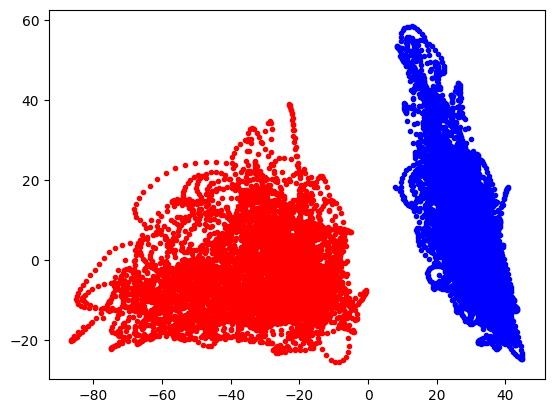

In [35]:
plt.scatter(X_train_anaesthesized_transformed[:,0].flatten(),X_train_anaesthesized_transformed[:,1].flatten(),marker = ".",color="b")
plt.scatter(X_train_awake_transformed[:,0].flatten(),X_train_awake_transformed[:,1].flatten(),marker = ".",color="r")

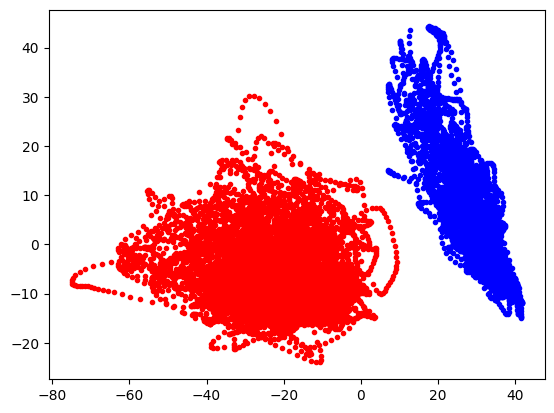

In [33]:
plt.scatter(X_test_anaesthesized_transformed[:,0].flatten(),X_test_anaesthesized_transformed[:,1].flatten(),marker = ".",color="b")
plt.scatter(X_test_awake_transformed[:,0].flatten(),X_test_awake_transformed[:,1].flatten(),marker = ".",color="r")

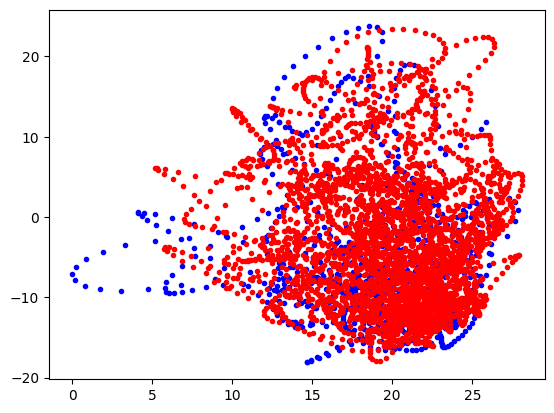

In [10]:
plt.scatter(X_test_light_propofol_transformed[:,0].flatten(),X_test_light_propofol_transformed[:,1].flatten(),marker = ".",color="b")
plt.scatter(X_test_deep_propofol_transformed[:,0].flatten(),X_test_deep_propofol_transformed[:,1].flatten(),marker = ".",color="r")

### Deep vs Light propofol

In [22]:
alpha = 0.01

a,b,c = fc_train_deep_propofol_vector.shape
X = fc_train_deep_propofol_vector.reshape((a*b,c))

d,e,f = fc_train_light_propofol_vector.shape
Y = fc_train_light_propofol_vector.reshape((d*e,f))

scalerX = StandardScaler().fit(X)
X = scalerX.transform(X)
C_X = (X.T @ X) / X.shape[0]

scalerY = StandardScaler().fit(Y)
Y = scalerX.transform(Y)
C_Y = (Y.T @ Y) / Y.shape[0]

C = C_X - alpha * C_Y

In [23]:
eig = sc.linalg.eig(C)
eigenvectors = eig[1]
eigenvalues = eig[0]

In [24]:
X_transformed = X @ eigenvectors

In [25]:
a,b,c = fc_train_anaesthesized_vector.shape
X_train_anaesthesized = fc_train_anaesthesized_vector.reshape((a*b,c))
X_train_anaesthesized = scalerX.transform(X_train_anaesthesized)
X_train_anaesthesized_transformed = X_train_anaesthesized @ eigenvectors

d,e,f = fc_train_awake_vector.shape
X_train_awake = fc_train_awake_vector.reshape((d*e,f))
X_train_awake = scalerY.transform(X_train_awake)
X_train_awake_transformed = X_train_awake @ eigenvectors

a,b,c = fc_train_light_propofol_vector.shape
X_train_light_propofol = fc_train_light_propofol_vector.reshape((a*b,c))
X_train_light_propofol = scalerX.transform(X_train_light_propofol)
X_train_light_propofol_transformed = X_train_light_propofol @ eigenvectors

d,e,f = fc_train_deep_propofol_vector.shape
X_train_deep_propofol = fc_train_deep_propofol_vector.reshape((d*e,f))
X_train_deep_propofol = scalerX.transform(X_train_deep_propofol)
X_train_deep_propofol_transformed = X_train_deep_propofol @ eigenvectors

a,b,c = fc_test_anaesthesized_vector.shape
X_test_anaesthesized = fc_test_anaesthesized_vector.reshape((a*b,c))
X_test_anaesthesized = scalerX.transform(X_test_anaesthesized)
X_test_anaesthesized_transformed = X_test_anaesthesized @ eigenvectors

d,e,f = fc_test_awake_vector.shape
X_test_awake = fc_test_awake_vector.reshape((d*e,f))
X_test_awake = scalerY.transform(X_test_awake)
X_test_awake_transformed = X_test_awake @ eigenvectors

a,b,c = fc_test_light_propofol_vector.shape
X_test_light_propofol = fc_test_light_propofol_vector.reshape((a*b,c))
X_test_light_propofol = scalerX.transform(X_test_light_propofol)
X_test_light_propofol_transformed = X_test_light_propofol @ eigenvectors

d,e,f = fc_test_deep_propofol_vector.shape
X_test_deep_propofol = fc_test_deep_propofol_vector.reshape((d*e,f))
X_test_deep_propofol = scalerX.transform(X_test_deep_propofol)
X_test_deep_propofol_transformed = X_test_deep_propofol @ eigenvectors

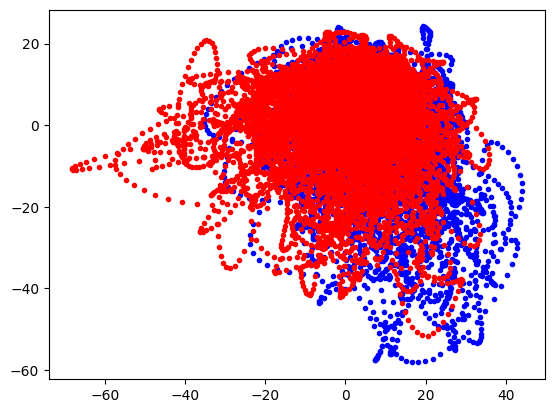

In [28]:
plt.scatter(X_train_light_propofol_transformed[:,0].flatten(),X_train_light_propofol_transformed[:,1].flatten(),marker = ".",color="b")
plt.scatter(X_train_deep_propofol_transformed[:,0].flatten(),X_train_deep_propofol_transformed[:,1].flatten(),marker = ".",color="r")

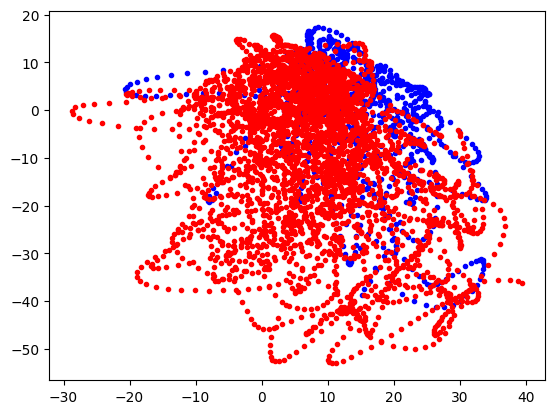

In [27]:
plt.scatter(X_test_light_propofol_transformed[:,0].flatten(),X_test_light_propofol_transformed[:,1].flatten(),marker = ".",color="b")
plt.scatter(X_test_deep_propofol_transformed[:,0].flatten(),X_test_deep_propofol_transformed[:,1].flatten(),marker = ".",color="r")